# Analysis of the Hackers.log file.
This is my small analysis on the log files, in which I will tryout my Regular Exp - abilities.<br>
————<br>
_Feel free to run the cells from top to bottom without worry! (You may need to install some of the libraries along the way... but that is easy at it look. Enjoy._

To follow along with this notebook: please download these 2 files. <br>
2 Files: [Here](https://1drv.ms/u/s!AvfjgvTsKfX4jS_tNCG138WNvymv?e=iIbpn5)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict

import nltk
import re

*This ↓ is the LogFile that I have converted from .log to .csv, for easier access.*

In [2]:
data = pd.read_csv("./hackersLog", header= None)

###### 

##### Creating patterns for Notification - Chat - Renames

In [3]:
pat_Notification = r"(^\d{2}\:\d{2}) (-!-) (.+?) (\[.+?\]) (.+)"

In [4]:
pat_Chat = r"(^\d{2}\:\d{2}\b) (\<.+?\>) (.+)"

In [5]:
pat_Known_as = r"(^\d{2}\:\d{2})( -!- )([a-z0-9\'\":;\{\}`~!@#$%^\\\/&*().+_|\-\[\]]+)( (is )?now known as )(.+)"

# 

## Getting the log open date

There are two types of dates, Log Starting date and normal date when the day changes. Here I am extracting all the dates when the Log is opened.

In [6]:
open_log = r"(--- Log opened)(.+)"

In [7]:
open_time = data.iloc[:, 0].str.extract(open_log, flags= re.I | re.M)

In [8]:
open_time.drop(0, axis= 1, inplace= True)

In [9]:
open_time.columns = ["dayLog"]

In [10]:
open_time[open_time.notna().any(1)]

,dayLog
1,Tue Sep 20 00:01:49 2016
3929,Thu Sep 22 23:57:59 2016
9280,Mon Sep 26 14:48:05 2016
12178,Wed Sep 28 22:45:15 2016
14253,Fri Sep 30 17:53:45 2016
...,...
475934,Thu Apr 26 21:22:07 2018
476364,Fri Apr 27 21:22:08 2018
476912,Sat Apr 28 21:22:09 2018
477647,Sun Apr 29 21:22:09 2018


# 

Now getting the changing day data.

## Getting Day Changed data (which will be helpful later) 

In [11]:
day_change = r"(--- Day changed) (.+)"

In [12]:
day_change = data.iloc[:, 0].str.extract(day_change, flags= re.I | re.M)

In [13]:
day_change.drop(0, axis= 1, inplace= True)

In [14]:
day_change.columns = ["dayChange"]

In [15]:
day_change[day_change.notna().any(1)]

,dayChange
0,Tue Sep 20 2016
917,Wed Sep 21 2016
2359,Thu Sep 22 2016
3935,Fri Sep 23 2016
5091,Sat Sep 24 2016
...,...
475968,Fri Apr 27 2018
476412,Sat Apr 28 2018
477278,Sun Apr 29 2018
477679,Mon Apr 30 2018


# 

# 

### Concatinating data

In [27]:
merged = pd.concat([data, open_time, day_change], axis= 1)

In [28]:
merged

,0,dayLog,dayChange
0,--- Day changed Tue Sep 20 2016,NaN,Tue Sep 20 2016
1,--- Log opened Tue Sep 20 00:01:49 2016,Tue Sep 20 00:01:49 2016,NaN
2,00:01 -!- Guest40341 [AndChat2541@AN-pl0gl1.8e...,NaN,NaN
3,00:11 -!- peejr [peeejr@AN-sru.3ib.ec0efc.IP] ...,NaN,NaN
4,00:14 -!- Gilgamesh [Gilgamesh@AN-nkf.mv0.se35...,NaN,NaN
...,...,...,...
478900,19:26 -!- hypnotic [hypnotic@One.Shot.One.Kill...,NaN,NaN
478901,19:29 <+Cogitabundus> Some like chaos.,NaN,NaN
478902,19:29 <+Cogitabundus> Oh they left.,NaN,NaN
478903,19:34 < DeTH> theres plenty of wreckless alpha...,NaN,NaN


Now we have the Merged DF, which will be so helpful in the upcoming massage of data. It has all the available information for each operation (ie. message or notification).

If you see, in most of the rows we have the Nulls — because the iformation of Date is only available in the single line, now we need to make them available in all lines. So we will use `ffill`. <br>
——<br>
Feel safe to use 'ffill', it will not create any false information. I have tested many times and it turnes out to be correct.

In [29]:
# Here making sure the raw date doesn't have Spaces.
merged.dayChange = merged.dayChange.str.strip()
merged.dayLog = merged.dayLog.str.strip()

In [30]:
# Now converting the raw datetime into timestamps! (So exciting!)
merged.dayLog = pd.to_datetime(merged.dayLog, format= "%a %b %d %H:%M:%S %Y")
merged.dayChange = pd.to_datetime(merged.dayChange, format= "%a %b %d %Y")

In [31]:
# Now performing 'ffill'
merged.dayLog = merged.dayLog.fillna(method= "ffill")
merged.dayChange = merged.dayChange.fillna(method= "ffill")

The data till here looks like

In [32]:
merged

,0,dayLog,dayChange
0,--- Day changed Tue Sep 20 2016,NaT,2016-09-20
1,--- Log opened Tue Sep 20 00:01:49 2016,2016-09-20 00:01:49,2016-09-20
2,00:01 -!- Guest40341 [AndChat2541@AN-pl0gl1.8e...,2016-09-20 00:01:49,2016-09-20
3,00:11 -!- peejr [peeejr@AN-sru.3ib.ec0efc.IP] ...,2016-09-20 00:01:49,2016-09-20
4,00:14 -!- Gilgamesh [Gilgamesh@AN-nkf.mv0.se35...,2016-09-20 00:01:49,2016-09-20
...,...,...,...
478900,19:26 -!- hypnotic [hypnotic@One.Shot.One.Kill...,2018-04-30 21:22:08,2018-05-01
478901,19:29 <+Cogitabundus> Some like chaos.,2018-04-30 21:22:08,2018-05-01
478902,19:29 <+Cogitabundus> Oh they left.,2018-04-30 21:22:08,2018-05-01
478903,19:34 < DeTH> theres plenty of wreckless alpha...,2018-04-30 21:22:08,2018-05-01


In [33]:
# As we don't need the TIME information — at when the log was started
# we can ignore the time from datetim
merged.dayLog = merged.dayLog.apply(lambda x: x.date())

In [34]:
# Convering back — to datetime because now it is object type
merged.dayLog = merged.dayLog.astype(np.datetime64)

Now it looks like... ↓

In [35]:
merged

,0,dayLog,dayChange
0,--- Day changed Tue Sep 20 2016,NaT,2016-09-20
1,--- Log opened Tue Sep 20 00:01:49 2016,2016-09-20,2016-09-20
2,00:01 -!- Guest40341 [AndChat2541@AN-pl0gl1.8e...,2016-09-20,2016-09-20
3,00:11 -!- peejr [peeejr@AN-sru.3ib.ec0efc.IP] ...,2016-09-20,2016-09-20
4,00:14 -!- Gilgamesh [Gilgamesh@AN-nkf.mv0.se35...,2016-09-20,2016-09-20
...,...,...,...
478900,19:26 -!- hypnotic [hypnotic@One.Shot.One.Kill...,2018-04-30,2018-05-01
478901,19:29 <+Cogitabundus> Some like chaos.,2018-04-30,2018-05-01
478902,19:29 <+Cogitabundus> Oh they left.,2018-04-30,2018-05-01
478903,19:34 < DeTH> theres plenty of wreckless alpha...,2018-04-30,2018-05-01


It might seem that both dates are same, but the DayChange is DayWise and changes each day, while the dayLog doesn't ... mean's it is not based on dayChange.

# 

### Now, Extraction of Types of messages
If you see in the merge dataframe, there is only single column of things. Column `0`. It has ALL / EVERY information of whole log.

Now it is my job to extract relavant information.

**Before moving forward:** I would like to make things clear that - this is the log of many groups and there are multiple actions inside of it. And each of them are with their our patterns. Some of the actions are:
* Message sending
* Joining the conversation
* Leaving the conversation
* Group names
* Ip addresses
* Changing the mode of group
* Making someone an admin
* Changing the name

And couple of others... <br>
—— <br>
But here, I have selected THE MOST common and mostly done things: Joining, Changing name - and sending message.

You can explore more on your own. But man! Just with these 3 things, Many many things are possible. <br> 
**Just keep scrolling!**

In [36]:
# Rows with Notification (Join, Quit, Leave)
_1 = merged.iloc[:, 0].str.extract(pat_Notification, flags= re.M|re.I)
_1["dayLog"] = merged.dayLog
_1["dayChange"] = merged.dayChange

In [37]:
# Rows with Message send
_2 = merged.iloc[:, 0].str.extract(pat_Chat, flags= re.I|re.M)
_2["dayLog"] = merged.dayLog
_2["dayChange"] = merged.dayChange

In [38]:
# Rows with Renaming
_3 = merged.iloc[:, 0].str.extract(pat_Known_as, flags= re.I|re.M)
_3["dayLog"] = merged.dayLog
_3["dayChange"] = merged.dayChange

As I have told you, there are multiple things to be done but I have selected only 3. Now to prove that... see below ↓

In [39]:
Not_match = data[(_1.isna().any(1) == _2.isna().any(1)) == _3.isna().any(1)]

In [40]:
Not_match.size

3754

This shows that out of `4,78,905` rows of data these 3 things occupy 478905 - 3754 = `475151` rows!

That means the rest of rows are just 3754, or - `0.78%` of total rows.

# 

In [45]:
# Renaming our DFs and dropping the un-necessary. 
Notifs = _1
Chats = _2
Renams = _3

In [46]:
del _1; del _2; del _3

# 

Renaming columns of each DF

In [48]:
Notifs.columns = ['time', 'type', 'uname', 'ip', 'action', 'dayLog', 'dayChange']
Notifs.dropna(inplace= True)
Notifs.drop(["type", "ip"], axis= 1, inplace= True)

###### 

In [49]:
Chats.columns = ['time', 'uname', 'message', 'dayLog', 'dayChange']
Chats = Chats.dropna()

###### 

In [51]:
Renams.columns = ["time", "type", "old_name", "message", "_", "new_name", 'dayLog', 'dayChange']
Renams = Renams.dropna()

###### 

# 

In [53]:
Notifs.sample(3)

,time,uname,action,dayLog,dayChange
239231,03:49,hasNoClue,has quit [Client exited],2017-05-03,2017-05-04
404311,12:01,yasbarh,has quit [Quit: Page closed],2017-12-11,2017-12-12
207781,18:22,xAcex,has quit [Connection closed],2017-04-02,2017-04-03


In [54]:
Chats.sample(3)

,time,uname,message,dayLog,dayChange
331315,03:53,<+evilbot>,hashcatplus - a GPGPU-based multi-hash cracker,2017-08-22,2017-08-23
39659,00:50,< Shaitan>,"thats cool, i dont judge anybody or anything, ...",2016-10-17,2016-10-19
93254,17:47,< catface>,"""defcon sql"" its being hosted by a black guy",2016-11-21,2016-11-21


In [55]:
Renams.sample(3)

,time,type,old_name,message,_,new_name,dayLog,dayChange
334300,17:59,-!-,Garb-Anti-Odor,is now known as,is,Cheseburger,2017-08-26,2017-08-27
437556,10:40,-!-,Guest11299,is now known as,is,fried_potato,2018-02-18,2018-02-19
254543,15:44,-!-,[S],is now known as,is,Guest43023,2017-05-19,2017-05-20


Now, if you see - we hae 'time' column in very first of each df, that is time - but it is without the information of date. 

In the further exploration and operations we need the date info attatched with that time to aviod the time operlapping issues.

In [56]:
# Creating a function to merge time and date
def merge_time(time_date):
    time = time_date[0]
    date = time_date[1].strftime("%Y-%m-%d")
    merged = datetime.strptime(date + ' ' + time, "%Y-%m-%d %H:%M")
    return merged

In [57]:
Chats.time = Chats[['time', 'dayChange']].apply(merge_time, axis= 1)

In [58]:
Notifs.time = Notifs[['time', 'dayChange']].apply(merge_time, axis= 1)

In [59]:
Renams.time = Renams[['time', 'dayChange']].apply(merge_time, axis= 1)

##### Easy! 

# 

## Now main tables that we have are Chats and Notifs

`Chats` represent the messages transferred on that day and `Notifs` informs who joind on that day

In [244]:
Chats.sample(5)

,time,uname,message,dayLog,dayChange
99811,2016-11-26 15:51:00,<@guapo>,applepie: I guess that you will never lend you...,2016-11-23,2016-11-26
154015,2017-01-31 00:04:00,< blueandnew>,i cant have more than 10 tabs opeb,2017-01-30,2017-01-31
6357,2016-09-25 01:18:00,<+evilbot>,maltego - an open source intelligence and fore...,2016-09-22,2016-09-25
458671,2018-03-22 00:27:00,< intravenous>,ok,2018-03-21,2018-03-22
61519,2016-11-03 00:49:00,<@guapo>,lol,2016-11-01,2016-11-03


In [245]:
Notifs.sample(5)

,time,uname,action,dayLog,dayChange
147192,2017-01-22 02:15:00,Freak,has quit [Ping timeout: 121 seconds],2017-01-21,2017-01-22
149990,2017-01-25 17:39:00,mugg,has joined #hackers,2017-01-24,2017-01-25
216349,2017-04-13 00:40:00,kaijectorsf,has joined #hackers,2017-04-12,2017-04-13
473812,2018-04-22 20:44:00,lonelykiller,has joined #hackers,2018-04-21,2018-04-22
456957,2018-03-19 18:46:00,moyless4p3y,has quit [Connection closed],2018-03-18,2018-03-19


# 

# <font face="neuville" style="font-size:100px"> <center> Starting Analysis </center> </font>

**NOTE** -- Please -- **NOTE** <br>
The following codes are SO COMPUTATIONLY INTENSIVE. So I suggest to Download the ready file from [here](https://1drv.ms/u/s!AvfjgvTsKfX4jS_tNCG138WNvymv?e=iIbpn5) and then write the code like...  (file size is approx: 180 MB)

```python
with pd.HDFStore('./pre_computed.h5') as file:
    print(file.keys())
```

The expression above will show all keys in that file. Then store as in your variables are they needed. Access them in this way...

```python
df_name = file['key']
```

Now, not in all code you will need to fetch the data, you can run them too. I will note `OKAY TO RUN` or `DON'T` RUN respectively.

# 

# Q1. Number of people who Joined BUT hadn't Written anything

This means those people who are in there when the log / session started - but they didn't write anything or sent any message during that log. So... here is how it goes.

In [61]:
'OKAY TO RUN'
# Daywise grouping unique names who JOINED
daywise_notifs = Notifs.groupby("dayLog")['uname'].apply(lambda g: g.unique())
daywise_notifs

dayLog
2016-09-20    [Guest40341, peejr, Gilgamesh, _CyBruh_, Bobse...
2016-09-22    [ranbo2, emmaaa, Trionex_, bigbadwolf, razepun...
2016-09-26    [ranbo2, pr0m37h3u5, pokefucker, gmago, Numb3r...
2016-09-28    [ranbo2, Winston, Guest54480, Nitr0, Moriarty,...
2016-09-30    [ranbo2, gre1v__, gre1v___, Mavis, fatbedridde...
                                    ...                        
2018-04-26    [ranbo2, fleming, systemd, twelve, mode/#hacke...
2018-04-27    [ranbo2, Hex, sheldon, Llocker, multijust, Joh...
2018-04-28    [ranbo2, Bl4xPirat3_CreW, Bl4xPirat3_CreW_, TH...
2018-04-29    [ranbo2, twelve, maxmuster, dobs, Nitr0, DJDiv...
2018-04-30    [ranbo2, Sho_0e, sho_0es, psouth_, maxmuster, ...
Name: uname, Length: 491, dtype: object

In [62]:
'OKAY TO RUN'
# day wise users who CHATTED
daywise_chats = Chats.groupby("dayLog")['uname'].apply(lambda g: g.unique())
daywise_chats

dayLog
2016-09-20    [< ice231>, < HeavenGuard>, <+nemecy>, < Ctrl>...
2016-09-22    [<+nemecy>, < crackerjax>, < Iron1>, < doxer>,...
2016-09-26    [< pr0m37h3u5>, < pokefucker>, < keddy>, <%gua...
2016-09-28    [< sTrikEforCe>, < Winston>, < Demand>, <+evil...
2016-09-30    [< gr1ev>, < Moriarty>, < dedocne>, <@phusion>...
                                    ...                        
2018-04-26    [< acab>, < AnonSF>, < xData>, <%twelve>, < DJ...
2018-04-27    [< Guest5741>, < nemesys>, < alan>, < Zer0NetP...
2018-04-28    [< Bl4xPirat3_CreW>, <%twelve>, < lazarus>, < ...
2018-04-29    [< nemesys>, < maxmuster>, < CedEagle09>, < la...
2018-04-30    [< FreeAnons-089>, < BeatbyAnonymous>, < tobi>...
Name: uname, Length: 491, dtype: object

In [63]:
'OKAY TO RUN'
# Now making the df together
dayWise = pd.concat([daywise_notifs.rename("joined"), daywise_chats.rename("chatted")], axis= 1)
dayWise

,joined,chatted
dayLog,,
2016-09-20,"[Guest40341, peejr, Gilgamesh, _CyBruh_, Bobse...","[< ice231>, < HeavenGuard>, <+nemecy>, < Ctrl>..."
2016-09-22,"[ranbo2, emmaaa, Trionex_, bigbadwolf, razepun...","[<+nemecy>, < crackerjax>, < Iron1>, < doxer>,..."
2016-09-26,"[ranbo2, pr0m37h3u5, pokefucker, gmago, Numb3r...","[< pr0m37h3u5>, < pokefucker>, < keddy>, <%gua..."
2016-09-28,"[ranbo2, Winston, Guest54480, Nitr0, Moriarty,...","[< sTrikEforCe>, < Winston>, < Demand>, <+evil..."
2016-09-30,"[ranbo2, gre1v__, gre1v___, Mavis, fatbedridde...","[< gr1ev>, < Moriarty>, < dedocne>, <@phusion>..."
...,...,...
2018-04-26,"[ranbo2, fleming, systemd, twelve, mode/#hacke...","[< acab>, < AnonSF>, < xData>, <%twelve>, < DJ..."
2018-04-27,"[ranbo2, Hex, sheldon, Llocker, multijust, Joh...","[< Guest5741>, < nemesys>, < alan>, < Zer0NetP..."
2018-04-28,"[ranbo2, Bl4xPirat3_CreW, Bl4xPirat3_CreW_, TH...","[< Bl4xPirat3_CreW>, <%twelve>, < lazarus>, < ..."


In [64]:
# Making a function to get the difference
def check_if(both_names):
    join_names = both_names[0]
    chat_names = both_names[1]
    return pd.Series([len(join_names), len(chat_names), len(join_names) - len(chat_names)], index= ["Joined", "Chatted", "Not_Chatted"])

In [65]:
'OKAY TO RUN'
Not_chatted = dayWise.apply(check_if, axis= 1)
Not_chatted

,Joined,Chatted,Not_Chatted
dayLog,,,
2016-09-20,332,99,233
2016-09-22,394,115,279
2016-09-26,274,82,192
2016-09-28,250,66,184
2016-09-30,338,109,229
...,...,...,...
2018-04-26,88,18,70
2018-04-27,80,23,57
2018-04-28,87,22,65


This ↑ shows the day wise how many joind, chatted and how many didn't chat.

### "Not Chatters" day wise

<AxesSubplot:>

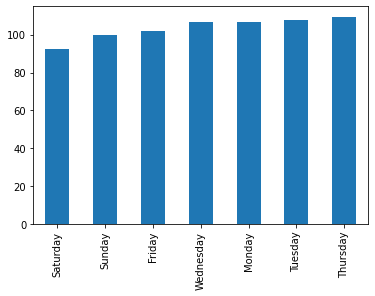

In [251]:
Not_chatted.groupby(lambda date: date.day_name()).Not_Chatted.mean().sort_values().plot(kind= "bar")

There is not a strong trend, NOT CHATTERS are less on Saturday which might make sense because they used to chat with others more on sat - on weekend and having time... (this is not for normal people though - it is hackers by the way!) 

# 

# Q2. Which users spent the most time in the logs?

For this I have to get all names of users - from all days and then need to check on each day When he entered and When he left. And also need to take care about if he or she enters again - that will be counted as well.

*NOTE: This is for EACH log. It is not for EACH day. So log is opened and closed on multiple days as well*

###### 

There are 3 possibilities to end the time of that person:
* He Quits (message Quit)
* He Lefts (message Left)
* Log ends (day changes)

Three of them will only be applied IF we have encountered the START message (join).

# 

### Q2.1 Getting for EACH session per log. 

In [66]:
'OKAY TO RUN'

# Here I am using the regex to extract the ACTION - to group then together
Notifs["short_action"] = Notifs.action.str.extract(r"(\b\w+\s\w+\b)", re.I)

In [67]:
Notifs.short_action.value_counts(0)

has joined         114562
has quit           109457
has left             4000
by EmmaWatson        3634
by evilbox             20
by satan               19
by guapo                9
by OperServ             8
by twelve               8
by keddy                7
by Iggy                 6
by phusion              6
by Logical              5
by BOFH                 4
by Cogitabundus         3
by AnonOps              1
Name: short_action, dtype: int64

We can see that there are 3 types of Actions that suggest the Entry or Exit of a person. Joined / Quit / Left

Here left means that the person has left the group. We can use it as the Quit while counting the Time.

# 

In [68]:
'OKAY TO RUN'

def count_stay(group, uname):
    """
    This function calculates the difference between join and leave
    based on the condition it will make its job done. If the log ends
    and that user hasn't left - it will auto matically end the session.
    
    THIS IS NOT FOR EACH LOG - IT IS GENERAL SESSION
    """
    
    start_time = False
    for i in group.iterrows():
        row = i[1]
        if row['short_action'] == "has joined":
            if start_time == False:
                start_time = row['time']
            else:
                names[uname].append(row['time'] - start_time)
                start_time = row['time']
        elif row['short_action'] in ["has quit", "has left"]:
            if start_time != False:
                names[uname].append(row['time'] - start_time)
                start_time = False
                
    if start_time != False:
        names[uname].append(row['time'] - start_time)

In [69]:
'OKAY TO RUN'
u_names = Notifs.uname.unique()

In [ ]:
"DON'T RUN"
# This loop will iteratively take each user's name and
# calculate their average session

names = defaultdict(list)
for th, name in enumerate(u_names):
    print(th, name)
    for_name = Notifs[Notifs.uname == name]
    for_name.groupby("dayLog")[['short_action', 'time']].apply(count_stay, uname= name)
    
names_ser = pd.Series(names)

###### 

**THAT IS DON't RUN** So you can get the already run file writing this: <br>


In [70]:
with pd.HDFStore("./cleaned_tables_3.h5") as file:
    names_ser = file['names_with_time']

###### 

In [71]:
names_ser

peejr           [0 days 00:09:00, 0 days 00:04:00, 0 days 00:0...
Gilgamesh       [0 days 00:16:00, 0 days 00:36:00, 0 days 00:1...
Bobseviltwin    [0 days 01:01:00, 0 days 00:53:00, 0 days 04:5...
Anonymous5      [0 days 00:10:00, 0 days 00:03:00, 0 days 00:3...
lazyNitr0       [0 days 15:26:00, 0 days 10:40:00, 0 days 02:2...
                                      ...                        
nemesys-                                        [0 days 00:00:00]
arrow                                           [0 days 01:28:00]
Guest24853                     [0 days 00:13:00, 0 days 00:00:00]
Nightyy                                         [0 days 00:01:00]
feakquency                                      [0 days 00:11:00]
Length: 14315, dtype: object

See that ↑ and ↓ are different. Which makes sense because not each user has stayed in the log or many of them have changed their names during the time. So... the unique names have to be larger.

In [269]:
len(u_names)

18761

# 

In [72]:
'OKAY TO RUN'

# Now, from that data we can extract the average session time
mean_stay_per_log = names_ser.apply(lambda x: np.array(x).mean())
mean_stay_per_log

peejr                    0 days 00:57:20
Gilgamesh                0 days 00:31:10
Bobseviltwin   0 days 02:10:27.945205479
Anonymous5     0 days 00:11:08.571428571
lazyNitr0         0 days 03:43:58.750000
                          ...           
nemesys-                 0 days 00:00:00
arrow                    0 days 01:28:00
Guest24853               0 days 00:06:30
Nightyy                  0 days 00:01:00
feakquency               0 days 00:11:00
Length: 14315, dtype: timedelta64[ns]

## Top 10 people who are kind of Most active. 

In [73]:
mean_stay_per_log.sort_values(ascending= False)[:10]

specialant      8 days 05:10:00
b               4 days 02:02:30
ipwn_           3 days 17:11:20
Guest36850      3 days 13:00:00
onlyr4spb3rry   3 days 06:31:00
FreeAnons-911   2 days 19:56:00
patamon         2 days 18:43:00
literallyfly    2 days 11:38:00
H0n             2 days 04:34:00
Meganium        2 days 03:48:00
dtype: timedelta64[ns]

# 

These are the top players! Now, if you see that - first one has got 8 days long online presence!<br>
— <br>
Well I have cross checked it, it is true! That person has loggned in and out after 8 days straight!

But he only has one presence (means one entry for in and one for out) so... we shouldn't count. Let's make one more metrics with the mean and counts.

##### 

Because there are people with only 1 or 2 sessions, they can influence the calculations. Let's also count their frequencies.

In [74]:
'OKAY TO RUN'

def mean_count(x):
    x = np.array(x)
    return pd.Series([x.mean(), len(x)], index=["mean", "count"])

In [75]:
'OKAY TO RUN'

mean_stay_per_log = names_ser.apply(mean_count)
mean_stay_per_log

,mean,count
peejr,0 days 00:57:20,9
Gilgamesh,0 days 00:31:10,18
Bobseviltwin,0 days 02:10:27.945205479,73
Anonymous5,0 days 00:11:08.571428571,7
lazyNitr0,0 days 03:43:58.750000,336
...,...,...
nemesys-,0 days 00:00:00,1
arrow,0 days 01:28:00,1
Guest24853,0 days 00:06:30,2
Nightyy,0 days 00:01:00,1


In [76]:
mean_stay_per_log['count'].mean()

8.002933985330074

In [77]:
mean_stay_per_log['count'].quantile(0.25)

1.0

In [78]:
mean_stay_per_log['count'].quantile(0.5)

1.0

In [79]:
mean_stay_per_log['count'].quantile(0.75)

3.0

We should take 10 as the deciding factor! 

<AxesSubplot:>

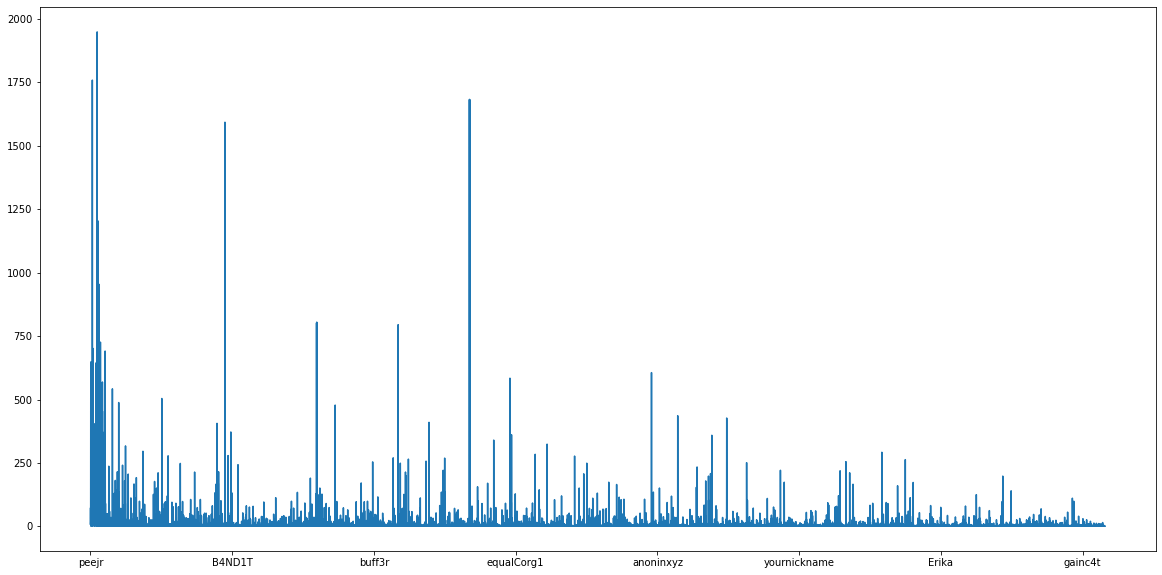

In [80]:
mean_stay_per_log['count'].plot(figsize= (20, 10))

In [81]:
mean_stay_per_log[mean_stay_per_log['count'] >= 10].sort_values(by= "mean", ascending= False)[:10]

,mean,count
eee,1 days 05:25:24,10
user,0 days 16:22:17.142857142,14
acacia,0 days 11:25:58.333333333,36
nusma,0 days 11:03:44,45
sTrikEforCe,0 days 10:58:31.836734693,49
ThePhoenix47,0 days 10:55:03.428571428,35
Flutts,0 days 10:02:55,12
c00lguy,0 days 09:26:57.777777777,27
AnonLord,0 days 09:19:48.750000,16
n16h75h4d0w,0 days 09:06:50.769230769,26


So... we have people who are staying active more than 1 day too!

Again, these numbers show the AVERAGE SESSION from entire data set. But the original question was average session per LOG. So that is ↓

##### 

### Q2.2 Average Session per log 
Now instead of counting session average, now we will count per log average.

In [82]:
'OKAY TO RUN'

def count_stay(group, uname):
    """
    This function is similar to the function above, (the long one)
    but the main difference is that this will calcualte for whole 
    log - instead of each seassion.
    """
    start_time = False
    each_log = []
    for i in group.iterrows():
        row = i[1]
        if row['short_action'] == "has joined":
            if start_time == False:
                start_time = row['time']
            else:
                each_log.append(row['time'] - start_time)
                start_time = row['time']
        elif row['short_action'] in ["has quit", "has left"]:
            if start_time != False:
                each_log.append(row['time'] - start_time)
                start_time = False
                
    if start_time != False:
        each_log.append(row['time'] - start_time)
    total_time = np.array(each_log).sum()
    if total_time != 0:
        names[uname].append(total_time)

In [83]:
'OKAY TO RUN'
u_names = Notifs.uname.unique()

In [ ]:
"DON'T RUN"

names = defaultdict(list)
for th, name in enumerate(u_names):
    print(th, name)
    for_name = Notifs[Notifs.uname == name]
    for_name.groupby("dayLog")[['short_action', 'time']].apply(count_stay, uname= name)
    
names_ser = pd.Series(names)

##### 

##### **THAT IS DON't RUN** So you can get the already run file writing this: <br>


In [94]:
with pd.HDFStore("./cleaned_tables_3.h5") as file:
    names_ser = file["names_per_log"]

##### 

In [95]:
def mean_count(x):
    x = np.array(x)
    return pd.Series([x.mean(), len(x)], index=["mean", "count"])

In [96]:
'OKAY TO RUN'

mean_stay_per_log = names_ser.apply(mean_count)
mean_stay_per_log

,mean,count
peejr,0 days 02:52:00,3
Gilgamesh,0 days 01:52:12,5
Bobseviltwin,0 days 07:12:54.545454545,22
Anonymous5,0 days 00:15:36,5
lazyNitr0,0 days 04:25:55.547703180,283
...,...,...
nemesys-,0 days 00:00:00,1
arrow,0 days 01:28:00,1
Guest24853,0 days 00:13:00,1
Nightyy,0 days 00:01:00,1


In [97]:
'OKAY TO RUN'

# There was the mean median and Q1 Q3 near number 3.
# Filtering data with count more than 3.
mean_stay_per_log[mean_stay_per_log['count'] >= 3].sort_values(by= "mean", ascending= False)

,mean,count
offs3tzer0,3 days 05:53:12,5
bang,2 days 18:41:40,3
rute,2 days 03:37:00,4
eee,2 days 01:02:20,6
Guest39742,1 days 16:10:00,3
...,...,...
ajb_,0 days 00:00:00,4
WhoAmI__,0 days 00:00:00,3
Autismus_Primus,0 days 00:00:00,3
ansivirus__,0 days 00:00:00,4


Now this gives us the better idea, that per log, how much time does a user stay.

# 

## Q3. Which users logged in the most? 

Again, for this we would have to use our Notifs df. And we will count their login.

In [98]:
'OKAY TO RUN'

# filtering only with the action "has joined"
join_details = Notifs[Notifs.short_action == "has joined"]

In [99]:
# Top people whose count is the mose
join_details.groupby('uname').size().sort_values(ascending= False)[:10]

uname
Hex            1949
twelve         1759
xAcex          1683
native         1682
target_        1593
terrorista     1204
S1rLancelot     954
John297         805
doe896          802
scribbler       795
dtype: int64

From HEX to Sctibbler - we have the details about log in.

# 

# Q4. Find the most common words in chat

Finally we are to find the most common words from chat. I mean - our Chat df can be utilized.

In [101]:
from collections import Counter

In [102]:
'OKAY TO RUN'

# Using this technique will help us a lot.
common_words = Counter(" ".join(Chats["message"].str.lower()).split())

In [103]:
common_words = pd.Series(common_words)

In [104]:
common_words.sort_values(ascending= False)

a            40026
to           38794
the          36508
and          35971
i            35917
             ...  
jezuz            1
chiar            1
janz_?           1
neechan          1
wreckless        1
Length: 84256, dtype: int64

Of course the grramatical words will be the most repeated ones... but we can remove them by using the NLTK stopwords.

# 

### Now to address the common words in the english...
We can use the nltk stopwords. (Install them id you don't have them and run the cells as is)

In [106]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
stopwords = stopwords.words('english')

In [108]:
'OKAY TO RUN'
common_words[common_words.index.isin(common_words.index.difference(pd.Index(stopwords)))].sort_values(ascending= False)[:20]

-          28433
use         6403
network     5822
lol         5758
open        5570
like        5189
source      5137
know        4883
file        4283
get         4215
tool        4179
local       3867
?           3810
scanner     3755
used        3516
windows     3356
im          3207
need        3108
one         3081
web         3011
dtype: int64

The more cleaning can be done like removal of the special charecters, but from looking at these data, we have a good estimate on which words are most used. (Man 'use' is the most used!)

# 

# Q5. Count the total number of written messages (only those with actual text content)  

I don't think this makes sense... but if we try to look at the Chats df, all are the messages! So... there is no question. But still if you want to check for further exploration, we can go forward.

In [109]:
'OKAY TO RUN'
Chats.message.str.lower().value_counts()

lol                                                                                                                                             3027
hi                                                                                                                                              1745
-tools                                                                                                                                          1372
darkd0rk3r - dork searching and searches for local file inclusion and sql injection                                                             1194
nipper - used to make observations about the security configurations of many different device types such as routers, firewalls, and switches    1194
                                                                                                                                                ... 
eyy                                                                                                       

LOL! Is the most used as a separate message!

Now looking at the 3rd most commong message, I sense that the Q5. might make some sense here... let's see why the message is so formal!

In [110]:
# There is some message that seems like sent by bot. Checking
Chats[Chats.message.str.lower().str.contains("adminloginfinder - is a perl script that scans webservers for administrative login / control panel sections.")]

,time,uname,message,dayLog,dayChange
580,2016-09-20 18:54:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2016-09-20,2016-09-20
628,2016-09-20 19:42:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2016-09-20,2016-09-20
758,2016-09-20 20:55:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2016-09-20,2016-09-20
877,2016-09-20 23:37:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2016-09-20,2016-09-20
930,2016-09-21 00:10:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2016-09-20,2016-09-21
...,...,...,...,...,...
416404,2018-01-08 05:26:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2018-01-07,2018-01-08
416716,2018-01-08 20:27:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2018-01-07,2018-01-08
417761,2018-01-10 13:11:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2018-01-09,2018-01-10
417964,2018-01-10 20:45:00,<+evilbot>,AdminLoginFinder - is a perl script that scans...,2018-01-09,2018-01-10


Looking at the data, we see that - the message it self is send by some kind of bot. But it is itself a message. Now, we may need some kind of AI to sense it is the FORMAL message. But, we can drop the idea... and take another approach.

In [111]:
Chats.message.str.lower().value_counts()[:40]

lol                                                                                                                                                 3027
hi                                                                                                                                                  1745
-tools                                                                                                                                              1372
darkd0rk3r - dork searching and searches for local file inclusion and sql injection                                                                 1194
nipper - used to make observations about the security configurations of many different device types such as routers, firewalls, and switches        1194
hashid - identifies the different types of hashes used to encrypt data                                                                              1194
image-exiftool - provides an extensible set of perl modules to read and write meta

Looks like the bot sends the same message on each log... but...

Skipping this.

# 

# Q6. Summarize the users that posted the most messages

This one sounds cool. Let's do this.

Now, to summarize users - who posted the most messages means let's take top 10 users. <br>
We can include these things in the summary (for each individual user):
* How many messages posted
* Total time spent in the logs
* Average time DAILY
* Most used words in message
* Avg. message length
* Total times name changed
* Avg. Daily active time when message is sent more

In [112]:
# Grabbing users (top 10)
Chats.uname.value_counts()[:10]

<+evilbot>         30721
<@guapo>            8083
< sTrikEforCe>      5305
<@BOFH>             4449
< lazarus>          3923
< DeTH>             3028
< catface>          2939
< dd_>              2927
<+Meow>             2627
<+Cogitabundus>     2579
Name: uname, dtype: int64

In [113]:
'OKAY TO RUN'
active_users = Chats.uname.value_counts()[:10].index
active_users

Index(['<+evilbot>', '<@guapo>', '< sTrikEforCe>', '<@BOFH>', '< lazarus>',
       '< DeTH>', '< catface>', '< dd_>', '<+Meow>', '<+Cogitabundus>'],
      dtype='object')

Looking at the pattern, I see that - the FIRST letter just before the actual username - is the TYPE of the user, + suggests somethig, @ suggests somethings and the most of them are having the ' ' space. Which may suggest the regualr or normal user. 

Now we need to extract the names so that we can use them in the Notifs df

In [114]:
'OKAY TO RUN'

# Because both df Chats and Notifs - are having different format for username
# I am creating a single df to address them both

active_users = pd.concat([active_users.str.extract("<.(.+)>", flags= re.I), pd.Series(active_users)], axis= 1)
active_users.columns = ["notif_name", "chat_name"]
active_users

,notif_name,chat_name
0,evilbot,<+evilbot>
1,guapo,<@guapo>
2,sTrikEforCe,< sTrikEforCe>
3,BOFH,<@BOFH>
4,lazarus,< lazarus>
5,DeTH,< DeTH>
6,catface,< catface>
7,dd_,< dd_>
8,Meow,<+Meow>
9,Cogitabundus,<+Cogitabundus>


# 

##### How many messages posted

In [115]:
'OKAY TO RUN'
Chats[Chats.uname.isin(active_users.chat_name)].groupby("uname").size()

uname
< DeTH>             3028
< catface>          2939
< dd_>              2927
< lazarus>          3923
< sTrikEforCe>      5305
<+Cogitabundus>     2579
<+Meow>             2627
<+evilbot>         30721
<@BOFH>             4449
<@guapo>            8083
dtype: int64

##### 

##### Total time spent in the logs

*Here our WELL RESEARCHED! series will come in help*

In [117]:
'OKAY TO RUN'

with pd.HDFStore("./cleaned_tables_3.h5") as file:
    names_time = file["names_with_time"]

In [118]:
'OKAY TO RUN'
names_time[names_time.index.isin(active_users.notif_name)].apply(lambda x: np.array(x).sum()).sort_values(ascending= False)

Cogitabundus   56 days 10:13:00
catface        39 days 05:49:00
BOFH           37 days 14:14:00
guapo          33 days 18:21:00
DeTH           23 days 19:34:00
sTrikEforCe    22 days 09:48:00
lazarus        20 days 17:33:00
dd_            12 days 05:22:00
Meow            6 days 03:13:00
evilbot         3 days 07:33:00
dtype: timedelta64[ns]

##### 

##### Average time DAILY

For this we need again to group by DAY - instead of the log. And then do the same stuff... but this time with only 10 users.

In [119]:
'OKAY TO RUN'

notifs_for_daily = Notifs[Notifs.uname.isin(active_users.notif_name)]
notifs_for_daily

,time,uname,action,dayLog,dayChange,short_action
99,2016-09-20 03:43:00,guapo,has quit [Ping timeout: 121 seconds],2016-09-20,2016-09-20,has quit
176,2016-09-20 07:46:00,sTrikEforCe,has quit [Connection closed],2016-09-20,2016-09-20,has quit
277,2016-09-20 12:48:00,guapo,has joined #hackers,2016-09-20,2016-09-20,has joined
368,2016-09-20 14:56:00,DeTH,has joined #hackers,2016-09-20,2016-09-20,has joined
444,2016-09-20 15:14:00,DeTH,has quit [Ping timeout: 121 seconds],2016-09-20,2016-09-20,has quit
...,...,...,...,...,...,...
478778,2018-05-01 15:58:00,BOFH,has joined #hackers,2018-04-30,2018-05-01,has joined
478860,2018-05-01 17:25:00,Cogitabundus,has quit [Quit: Leaving],2018-04-30,2018-05-01,has quit
478861,2018-05-01 17:51:00,Cogitabundus,has joined #hackers,2018-04-30,2018-05-01,has joined
478872,2018-05-01 18:01:00,Cogitabundus,has quit [Ping timeout: 121 seconds],2018-04-30,2018-05-01,has quit


Now this will again take us the same kind of loop... which we had used to get the difference of Login and Logout for each user. 

But now, the situation is a bit different, we now need to take care of each user - each day. 

In [120]:
def count_stay(group, uname):
    """
    This is the third long function, which will count the
    time PER DAY. (before this we counted per session and per log)
    """
    
    start_time = False
    each_day = []
    for i in group.iterrows():
        row = i[1]
        if row['short_action'] == "has joined":
            if start_time == False:
                start_time = row['time']
            else:
                each_day.append(row['time'] - start_time)
                start_time = row['time']
        elif row['short_action'] in ["has quit", "has left"]:
            if start_time != False:
                each_day.append(row['time'] - start_time)
                start_time = False
                
    if start_time != False:
        each_day.append(row['time'] - start_time)
    total_time = np.array(each_day).sum()
    if total_time != 0:
        names[uname].append(total_time)

In [121]:
'OKAY TO RUN'
u_names = notifs_for_daily.uname.unique()

In [123]:
'OKAY TO RUN yes really! For only 10 people it is OKAY TO RUN'

names = defaultdict(list)
for th, name in enumerate(u_names):
    print(th, name)
    for_name = Notifs[Notifs.uname == name]
    for_name.groupby("dayChange")[['short_action', 'time']].apply(count_stay, uname= name)

0 guapo
1 sTrikEforCe
2 DeTH
3 catface
4 Cogitabundus
5 BOFH
6 lazarus
7 evilbot
8 dd_
9 Meow


In [125]:
# Converting in series for ease
names_ser = pd.Series(names)

In [126]:
def mean_count(x):
    x = np.array(x)
    return pd.Series([x.mean(), len(x)], index=["mean", "count"])

In [127]:
'OKAY TO RUN'

mean_stay_per_day = names_ser.apply(mean_count)
mean_stay_per_day.sort_values(by= 'mean', ascending= False)

,mean,count
catface,0 days 03:38:10.875000,160
lazarus,0 days 03:10:30.573248407,157
DeTH,0 days 03:01:54.193548387,124
Cogitabundus,0 days 02:14:26.415094339,318
dd_,0 days 02:06:50,42
BOFH,0 days 01:50:46.730769230,208
guapo,0 days 01:42:23.492063492,189
evilbot,0 days 01:13:54.782608695,23
sTrikEforCe,0 days 01:05:40.588235294,34
Meow,0 days 00:46:20.412371134,97


#### 

##### Most used words in the message (Top 1) 

In [128]:
'OKAY TO RUN'

# Constraining the dataframe of Chats to just 10 people (active)
chat_names_active = Chats[Chats.uname.isin(active_users.chat_name)]

# 

In [129]:
# Importing string because we need to remove the punctuations
import string

In [130]:
'OKAY TO RUN'
stopwords.extend(list(string.punctuation))

In [131]:
def get_common_words(uname):
    '''
    With many steps, it will get the common word (most common)
    per user and return it back
    '''
    user = chat_names_active[chat_names_active.uname == uname].message.str.lower()
    words = pd.Series(Counter(" ".join(user).split()))
    return words[words.index.isin(words.index.difference(stopwords))].sort_values(ascending= False)[:1]

In [132]:
'OKAY TO RUN'

names = defaultdict(object)
for uname in chat_names_active.uname.unique():
    most_common = get_common_words(uname)
    names[uname] = tuple([most_common.index[0], most_common[0]])

In [133]:
pd.Series(names)

< sTrikEforCe>       (guapo:, 269)
< DeTH>                (like, 106)
<+Cogitabundus>         (well, 83)
<+evilbot>         (network, 4924)
<@BOFH>                (like, 182)
< lazarus>              (yes, 173)
< catface>             (like, 156)
< dd_>                 (haha, 119)
<@guapo>                (lol, 303)
<+Meow>             (title:, 2261)
dtype: object

As it is easily digestable, the names are indices and then the common words by them are in the tuple with the counts *(grammar and stopwords have been removed)*

# 

##### Avg. message length

In [134]:
'OKAY TO RUN'
chat_names_active.groupby('uname').message.apply(lambda x: x.str.len().mean())

uname
< DeTH>            28.856011
< catface>         40.911875
< dd_>             37.602323
< lazarus>         21.894978
< sTrikEforCe>     50.379076
<+Cogitabundus>    36.182241
<+Meow>            79.483061
<+evilbot>         83.202174
<@BOFH>            40.119128
<@guapo>           25.670419
Name: message, dtype: float64

# 

#####  Total times names changed

Finally for the first time we can have the access to the Rename df.

In [32]:
Renams

,time,type,old_name,message,_,new_name,dayLog,dayChange
34,2016-09-20 01:31:00,-!-,hellboy,is now known as,is,Guest26312,2016-09-20,2016-09-20
38,2016-09-20 01:38:00,-!-,AndroUser2,is now known as,is,Guest25727,2016-09-20,2016-09-20
46,2016-09-20 01:54:00,-!-,AndroUser2,is now known as,is,Guest17978,2016-09-20,2016-09-20
49,2016-09-20 01:56:00,-!-,AndroUser2,is now known as,is,Guest65262,2016-09-20,2016-09-20
66,2016-09-20 02:21:00,-!-,Guest2385,is now known as,is,__desu__,2016-09-20,2016-09-20
...,...,...,...,...,...,...,...,...
478762,2018-05-01 14:58:00,-!-,raiz,is now known as,is,Guest6167,2018-04-30,2018-05-01
478763,2018-05-01 14:59:00,-!-,Guest6167,is now known as,is,raiz,2018-04-30,2018-05-01
478841,2018-05-01 16:56:00,-!-,anonunknown,is now known as,is,Guest59820,2018-04-30,2018-05-01
478865,2018-05-01 17:54:00,-!-,regyroman,is now known as,is,Guest64959,2018-04-30,2018-05-01


In [135]:
# Constraining to just 10 active users
renams_active = Renams[Renams.old_name.isin(active_users.notif_name)]
renams_active

,time,type,old_name,message,_,new_name,dayLog,dayChange
11070,2016-09-27 13:05:00,-!-,dd_,is now known as,is,Guest18625,2016-09-26,2016-09-27
22741,2016-10-07 22:39:00,-!-,BOFH,is now known as,is,EatenByAnAardvark,2016-10-06,2016-10-07
22751,2016-10-07 23:00:00,-!-,Cogitabundus,is now known as,is,cogitafungus,2016-10-06,2016-10-07
23265,2016-10-08 01:12:00,-!-,lazarus,is now known as,is,Guest64050,2016-10-06,2016-10-08
24047,2016-10-08 06:33:00,-!-,lazarus,is now known as,is,Guest25559,2016-10-06,2016-10-08
...,...,...,...,...,...,...,...,...
464979,2018-04-04 19:21:00,-!-,lazarus,is now known as,is,Guest20021,2018-04-03,2018-04-04
467955,2018-04-11 09:10:00,-!-,guapo,is now known as,is,Guest30229,2018-04-10,2018-04-11
472494,2018-04-20 08:21:00,-!-,guapo,is now known as,is,Guest48792,2018-04-19,2018-04-20
475334,2018-04-26 10:10:00,-!-,guapo,is now known as,is,Guest27802,2018-04-25,2018-04-26


In [137]:
'OKAY TO RUN'
renams_active.groupby("old_name").size()

old_name
BOFH             34
Cogitabundus     30
DeTH             35
Meow              2
catface           3
dd_               6
evilbot           1
guapo            27
lazarus         101
sTrikEforCe       1
dtype: int64

##### 

##### Time when most active (more message sent) 

This is a new kind of problem that we will try to addrress, here - we will do some pandas magic.

In [138]:
'OKAY TO RUN'

u_names = chat_names_active.uname.unique()
names_active = []
for name in u_names:
    temp = chat_names_active[chat_names_active.uname == name]
    names_active.append((name, temp.set_index('time').groupby(lambda time: time.hour + 1).size().idxmax()))
    
names_active = pd.Series(dict(names_active))
names_active

< sTrikEforCe>      4
< DeTH>             6
<+Cogitabundus>    20
<+evilbot>         19
<@BOFH>            24
< lazarus>         10
< catface>         21
< dd_>             17
<@guapo>           24
<+Meow>            19
dtype: int64

# 

If you are following this till now, the naming conventions should be the same as mine. So, let's get one variable loaded again, because that is overwritten.

In [143]:
with pd.HDFStore("./cleaned_tables_3.h5") as file:
    names_with_time = file['names_with_time']

# 

# Now that we have all data
Let's put them all together

> ALL ARE OKAY TO RUN FROM NOW.

In [145]:
# Total messages
total_num_messages = Chats[Chats.uname.isin(active_users.chat_name)].groupby("uname").size()

In [146]:
# Total time spent in logs
time_spent_logs = names_with_time[names_with_time.index.isin(active_users.notif_name)].apply(lambda x: np.array(x).sum()).sort_values(ascending= False)

In [147]:
# Average time spend per day
mean_stay_per_day = names_ser.apply(mean_count)
mean_stay_per_day = mean_stay_per_day.sort_values(by= 'mean', ascending= False)

In [148]:
# Common words
names = defaultdict(object)
for uname in chat_names_active.uname.unique():
    most_common = get_common_words(uname)
    names[uname] = tuple([most_common.index[0], most_common[0]])
    
common_words = pd.Series(names)

In [149]:
# Average Message length
message_length = chat_names_active.groupby('uname').message.apply(lambda x: x.str.len().mean())

In [150]:
# Made renames
renames_made = renams_active.groupby("old_name").size()

In [151]:
# Active time hourly
u_names = chat_names_active.uname.unique()
names_active = []
for name in u_names:
    temp = chat_names_active[chat_names_active.uname == name]
    names_active.append((name, temp.set_index('time').groupby(lambda time: time.hour + 1).size().idxmax()))
    
names_active = pd.Series(dict(names_active))

### 

Now, extracting the user name when they are encoded in the brackets. So the merge becomes meaningful.

In [152]:
total_num_messages.index = total_num_messages.index.str.extract("<.(.+)>")[0]
message_length.index = message_length.index.str.extract("<.(.+)>")[0]
common_words.index = common_words.index.str.extract("<.(.+)>")[0]
names_active.index = names_active.index.str.extract("<.(.+)>")[0]

In [153]:
summary = pd.concat([total_num_messages, 
           time_spent_logs,
           mean_stay_per_day['mean'],
           common_words,
           message_length,
           renames_made,
           names_active], axis= 1)

summary.columns = ['Total Messages', 'Total Time Spent in Logs', 'Avg. Daily Active Time', 'Most Common Words', 'Avg. Message Length',
                   'Total Renames Made', 'Was most active on (24hr)']

summary['Avg. Daily Active Time'] = summary['Avg. Daily Active Time'].apply(lambda time: str(time.seconds//3600) + " Hours " + str((time.seconds//60) % 60)) + " Miutes"
summary

,Total Messages,Total Time Spent in Logs,Avg. Daily Active Time,Most Common Words,Avg. Message Length,Total Renames Made,Was most active on (24hr)
DeTH,3028,23 days 19:34:00,3 Hours 1 Miutes,"(like, 106)",28.856011,35,6
catface,2939,39 days 05:49:00,3 Hours 38 Miutes,"(like, 156)",40.911875,3,21
dd_,2927,12 days 05:22:00,2 Hours 6 Miutes,"(haha, 119)",37.602323,6,17
lazarus,3923,20 days 17:33:00,3 Hours 10 Miutes,"(yes, 173)",21.894978,101,10
sTrikEforCe,5305,22 days 09:48:00,1 Hours 5 Miutes,"(guapo:, 269)",50.379076,1,4
Cogitabundus,2579,56 days 10:13:00,2 Hours 14 Miutes,"(well, 83)",36.182241,30,20
Meow,2627,6 days 03:13:00,0 Hours 46 Miutes,"(title:, 2261)",79.483061,2,19
evilbot,30721,3 days 07:33:00,1 Hours 13 Miutes,"(network, 4924)",83.202174,1,19
BOFH,4449,37 days 14:14:00,1 Hours 50 Miutes,"(like, 182)",40.119128,34,24
guapo,8083,33 days 18:21:00,1 Hours 42 Miutes,"(lol, 303)",25.670419,27,24


I like that!

# 

# Q7. Find and Rank the Non-english words. (malware words too!) 

Here I will count the different words first. So... as we did before...

In [154]:
word_counts = pd.Series(Counter(" ".join(Chats.message.str.lower()).split()))

In [155]:
word_counts

anyone         1895
good           2865
with           6639
exploiting     1305
cisco            67
               ... 
"noob"            1
word).            1
wild?             1
consequence       1
wreckless         1
Length: 84256, dtype: int64

Now from the index, I will check for each word's presence in the Dict.

In [156]:
nltk.download('words')
from nltk.corpus import words

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [157]:
words = list(map(str.lower, words.words()))

In [158]:
words = set(words)

In [161]:
'THIS IS OKAY TO RUN - BUT WILL TAKE A WHILE '
wordmap = []
for word in word_counts.index:
    if word in words:
        wordmap.append(True)
    else:
        try:
            flat_word = re.sub("[.+!/\\?,;`~$#\'\"]", '', word)
            wordmap.append(flat_word in words)
        except Exception:
            wordmap.append(False)

In [162]:
word_counts_non_eng = word_counts[~np.array(wordmap)]

As we can see, there are 50K words which are not found in the dictionary. There is a strong chance that - those are because of the punctuations.

In [163]:
word_counts_non_eng

exploiting                                     1305
extrabacon?                                       2
op                                              204
trusted                                          26
services                                        174
                                               ... 
https://www.youtube.com/watch?v=ibvf7kuez78       1
havij.exe                                         1
"noob"                                            1
word).                                            1
wreckless                                         1
Length: 59883, dtype: int64

# 

In [164]:
import string
punc = string.punctuation

In [165]:
word_counts_non_eng = word_counts_non_eng[~word_counts_non_eng.index.isin(list(punc))]

In [166]:
word_counts_non_eng.sort_values(ascending= False)[:20]

lol         5758
windows     3356
im          3207
sql         2791
users       2609
perl        2540
types       2472
auditing    2422
i'm         2415
title:      2265
using       1932
tools       1897
shit        1855
has         1840
:)          1591
nmap        1581
files       1522
sites       1498
-tools      1433
fuck        1414
dtype: int64

I know thses are not going to be correct. But still... Ah, I don't know.

## 

# Q8. Which hour of the day had the most messages?

In [167]:
# grouping by hour
most_messages = Chats.set_index('time').groupby(lambda x: x.hour + 1).size().sort_values(ascending= False)

In [168]:
most_messages

21    14901
20    14215
19    14029
24    13682
22    13632
23    13013
18    11829
1     11482
16    11430
17    11194
2     10253
3      9939
15     9269
4      9097
14     8218
5      7759
13     7342
6      7243
9      5792
12     5430
7      5233
10     5114
8      4826
11     4681
dtype: int64

Oh! It seems like the amount of messages are to most at 9 PM!

<AxesSubplot:>

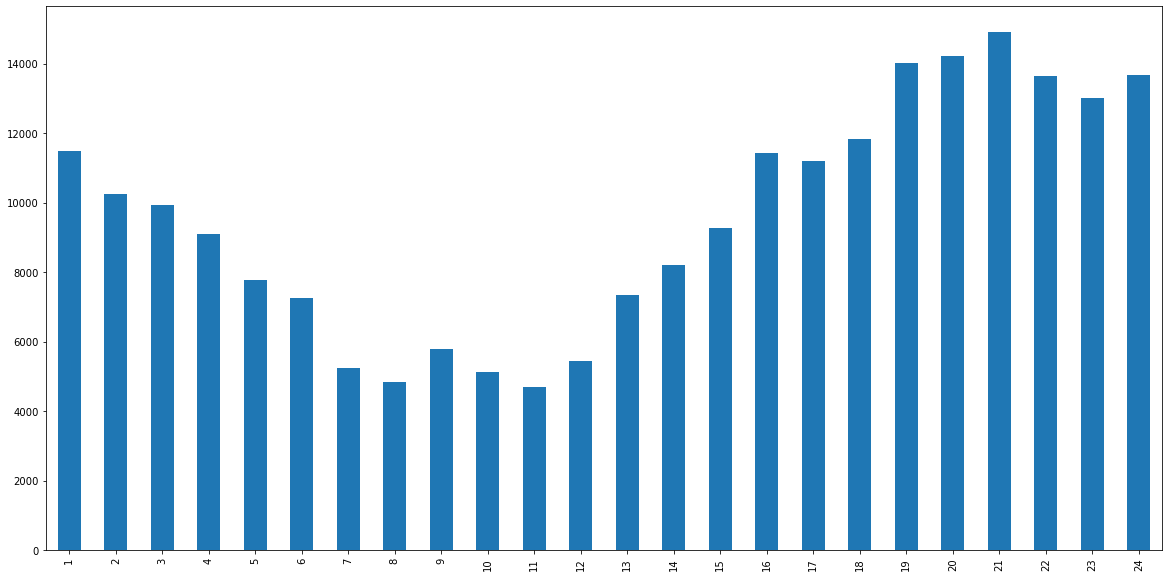

In [170]:
most_messages.sort_index().plot(kind= "bar", figsize= (20, 10))

# 

# Q9. Which days had the most amount of messages? 

In [172]:
# grouping by name of day
most_messages = Chats.set_index('time').groupby(lambda x: x.day_name()).size().sort_values(ascending= False)
most_messages

Saturday     37217
Friday       36405
Wednesday    33341
Thursday     32109
Tuesday      30848
Monday       30235
Sunday       29448
dtype: int64

<AxesSubplot:>

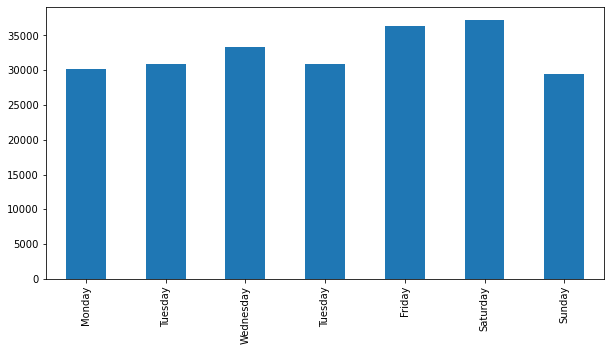

In [173]:
most_messages.reindex(['Monday', 'Tuesday',
                       'Wednesday', 'Tuesday',
                       'Friday', 'Saturday',
                       'Sunday']).plot(kind= "bar", figsize= (10, 5))

# 

# Q9. The posted URL 

This is again amazing! Here I have used a cool pattern which can recognize a url. Check it!

In [174]:
Chats.message.to_csv("messages", index= False)

In [175]:
amazing_url_pattern = r"(https?:\/\/[a-z]+\.[a-z-_+0-9]+\.[a-z]{0,5}[\\\/a-z0-9!@#$%^&*().=?><:;`_~-]+\b)|(https?:\/\/[a-z-_+0-9]+\.[a-z]{0,5}[\\/a-z0-9!@#$%^&*().=?><:;`_~-]+\b)|([a-z]+\.[a-z-_+0-9]+\.[a-z]{0,5}[\\/a-z0-9!@#$%^&*().=?><:;`_~-]+\b)"


In [177]:
'OKAY TO RUN'

urls= Chats.message.str.extract(amazing_url_pattern, flags= re.I | re.M)

In [180]:
# Focusing on only NonNulls
urls = urls[urls.notna().any(1)]

Till now...

In [181]:
urls

,0,1,2
225,http://i.imgur.com/PoCjYqQ.png,NaN,NaN
236,https://vid.pr0gramm.com/2015/08/28/8a9af17937...,NaN,NaN
239,NaN,NaN,www.ismoman.com
396,NaN,NaN,www.ismoman.com:2083
435,NaN,NaN,www.ismoman.com/wp-content/themes/ism
...,...,...,...
478475,https://www.ezecom.com.kh/newsdetail/hacked-by...,NaN,NaN
478479,NaN,http://flutehotel.com/index.php,NaN
478486,NaN,https://ghostbin.com/paste/r8g3e,NaN
478496,http://www.plainvilleks.com/Departments/Police...,NaN,NaN


In [182]:
# Filling where there are nulls
wow_url = urls[0].fillna(urls[1]).fillna(urls[2])

In [183]:
wow_url.reset_index(drop = True)

0                          http://i.imgur.com/PoCjYqQ.png
1       https://vid.pr0gramm.com/2015/08/28/8a9af17937...
2                                         www.ismoman.com
3                                    www.ismoman.com:2083
4                   www.ismoman.com/wp-content/themes/ism
                              ...                        
4976    https://www.ezecom.com.kh/newsdetail/hacked-by...
4977                      http://flutehotel.com/index.php
4978                     https://ghostbin.com/paste/r8g3e
4979    http://www.plainvilleks.com/Departments/Police...
4980          https://www.youtube.com/watch?v=IBvf7KUEZ78
Name: 0, Length: 4981, dtype: object

These are the urls! Total 4981 Found. 

# 

# That's it!
I know this is not too much as the EDA, it deserves a lot than this, but this was my try to demonstrate and practice the Regular Expressions. 

Thanks! <br>
Aayush ∞ Shah

# 